In [1]:
import os
import numpy as np
from sklearn.decomposition import NMF
from nmf_methods.nmf_son.new import new as nmf_son_new
from nmf_methods.nmf_son.new import new_2 as nmf_son_new_2
from nmf_methods.nmf_son.utils import save_results, load_results
import matplotlib.pyplot as plt

In [33]:
def sample_dirichlet(alpha, N):
    k = len(alpha)
    theta = np.zeros((N, k))
    scale = 1
    for i in range(k):
        theta[:, i] = np.random.gamma(alpha[i], scale, N)
    S = np.sum(theta, axis=1)
    theta = theta / np.tile(S.reshape(-1, 1), (1, k))
    return theta


def create_synthetic_data():
    Wt = np.array([[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1]])
    r = 4

    n = 500
    purity = 0.8
    alpha = 0.05 * np.ones((r, 1))
    Ht = sample_dirichlet(alpha, n).T
    for j in range(n):
        while np.max(Ht[:, j]) > purity:
            Ht[:, j: j+1] = sample_dirichlet(alpha, 1).T
    epsilon = 0.01
    Xt = np.dot(Wt, Ht)
    X = np.maximum(0, Xt + epsilon * np.random.randn(*Xt.shape))
    return X, Wt, Ht


def plot_3d(ax, X, Wt, W):
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='b', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='r', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='m', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)
    # if filepath:
    #     plt.savefig(filepath)
    # else:
    #     plt.show()

In [4]:
RUN = False

In [5]:
data_filepath = f'../../experimental/saved_models/toy/synthetic_data.npz'

if os.path.exists(data_filepath):
    data = np.load(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']
else:
    M, W_true, H_true = create_synthetic_data()
    with open(data_filepath, 'wb') as fout:
        np.savez_compressed(fout, M=M, W_true=W_true, H_true=H_true)

In [6]:
m, n = M.shape
max_iters = 10000
r = 4
ini_filepath = f'../../experimental/saved_models/toy/r{r}_ini.npz'

if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [ ]:
save_filepath = f'../../experimental/saved_models/toy/vanilla_r{r}_mit{max_iters}.npz'
img_filepath = f'../../experimental/images/toy/vanilla_r{r}_mit{max_iters}.png'

if RUN:
    model = NMF(n_components=r, init='custom', random_state=42, max_iter=max_iters)
    W = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
    H = model.components_
    with open(save_filepath, 'wb') as fout:
        np.savez_compressed(fout, W=W, H=H)
else:
    data = np.load(save_filepath)
    W = data['W']
    H = data['H']
    plot_3d(M, W_true, W, img_filepath)

In [6]:
lambda_vals = [0.0001, 0.005, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
save_filepath = '../../experimental/saved_models/toy/r{}_a_l{}_mit{}.npz'
img_filepath = '../../experimental/images/toy/r{}_a_l{}_mit{}.png'

# for _lam in lambda_vals:
#     if RUN:
#         W, H, fscores, gscores, lvals = nmf_son_new(M, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=max_iters, early_stop=True, verbose=False, scale_reg=True)
#         save_results(save_filepath.format(r, _lam, max_iters), W, H, fscores, gscores, lvals)
#     else:
#         W, H, fscores, gscores, lvals = load_results(save_filepath.format(r, _lam, max_iters))
#         plot_3d(M, W_true, W, img_filepath.format(r, _lam, max_iters))
#     print(_lam)

In [7]:
save_filepath = '../../experimental/saved_models/toy/r{}_b_l{}_mit{}.npz'
img_filepath = '../../experimental/images/toy/r{}_b_l{}_mit{}.png'

# for _lam in lambda_vals:
#     if ~RUN:
#         W, H, fscores, gscores, lvals = nmf_son_new_2(M, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=max_iters, early_stop=True, verbose=False, scale_reg=True)
#         save_results(save_filepath.format(r, _lam, max_iters), W, H, fscores, gscores, lvals)
#     else:
#         W, H, fscores, gscores, lvals = load_results(save_filepath.format(r, _lam, max_iters))
#         plot_3d(M, W_true, W, img_filepath.format(r, _lam, max_iters))
#     print(_lam)

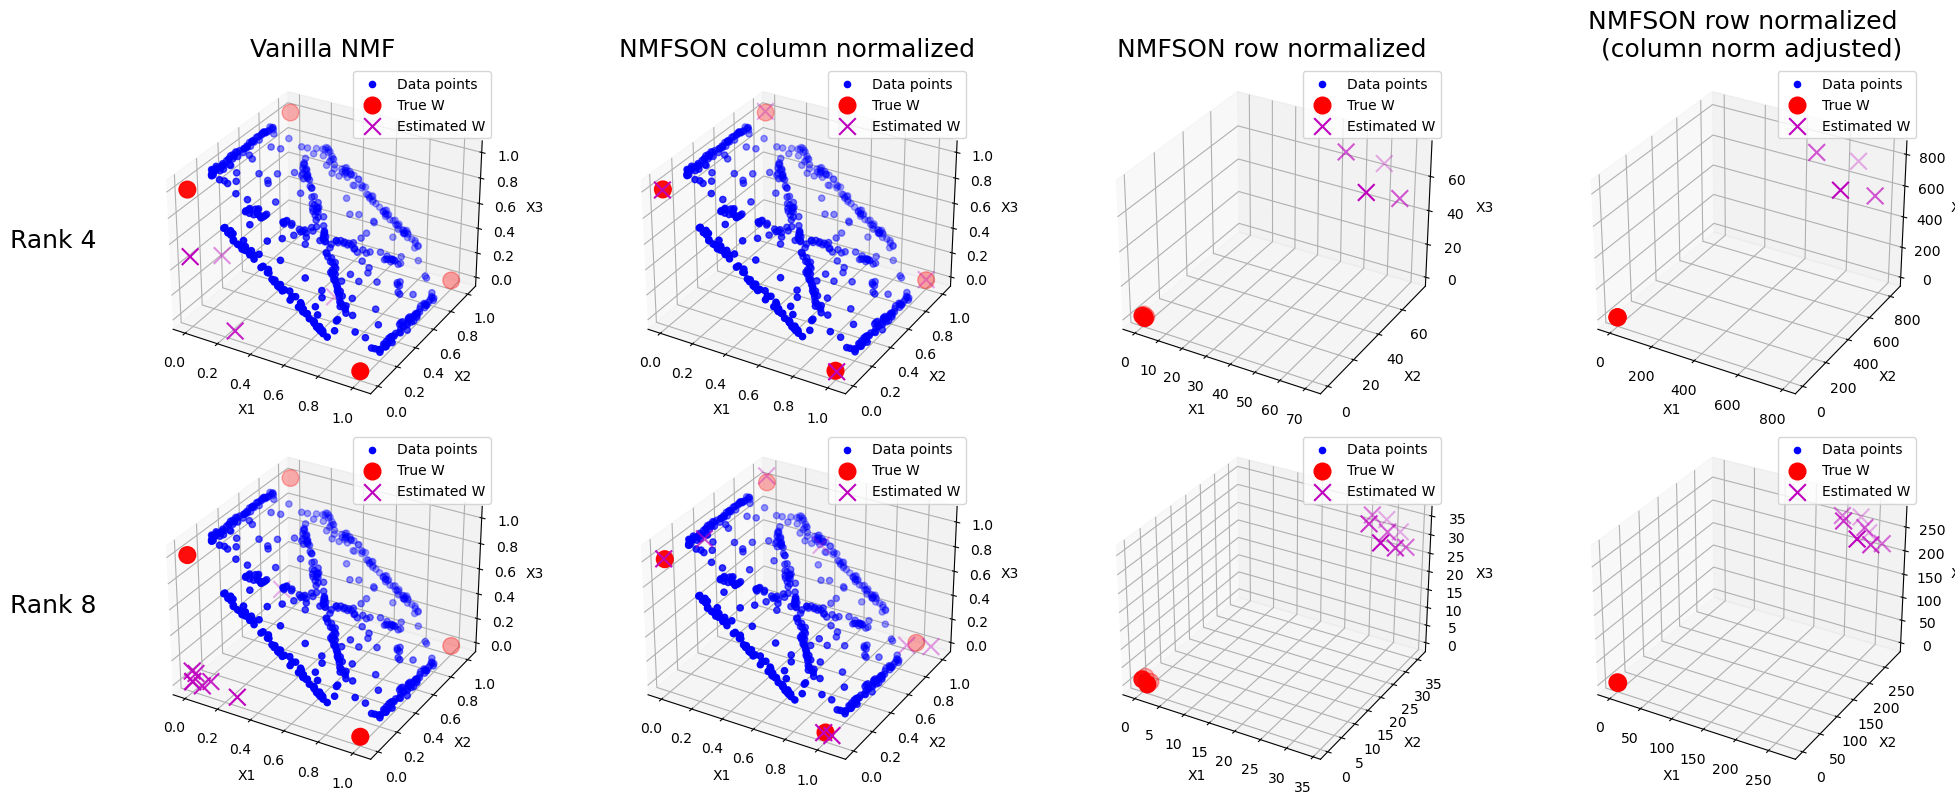

In [102]:
fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(2, 5, width_ratios=[0.1, 1, 1, 1, 1])

# set row and column labels
row_labels = ['Rank 4', 'Rank 8']
col_labels = ['Vanilla NMF', 'NMFSON column normalized', 'NMFSON row normalized', 'NMFSON row normalized \n (column norm adjusted)']

for i, rlabel in enumerate(row_labels):
    txt_ax = fig.add_subplot(gs[i, 0])
    txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=18)
    txt_ax.axis('off')


r = 4
vW1 = np.load('../../experimental/saved_models/toy/vanilla_r{}_mit{}.npz'.format(r, max_iters))['W']
c1 = fig.add_subplot(gs[0, 1], projection='3d')
plot_3d(c1, M, W_true, vW1)
c1.set_title(col_labels[0], fontsize=18)
cW1, _, _, _, _ = load_results('../../experimental/saved_models/toy/r{}_a_l{}_mit{}.npz'.format(r, 0.0001, max_iters))
c2 = fig.add_subplot(gs[0, 2], projection='3d')
plot_3d(c2, M, W_true, cW1)
c2.set_title(col_labels[1], fontsize=18)

rW1, rH1, _, _, _ = load_results('../../experimental/saved_models/toy/r{}_b_l{}_mit{}.npz'.format(r, 10, max_iters))
c3 = fig.add_subplot(gs[0, 3], projection='3d')
plot_3d(c3, M, W_true, rW1)
c3.set_title(col_labels[2], fontsize=18)

rH1_re = rH1 / np.linalg.norm(rH1, axis=0, keepdims=True)
rW1_re = rW1 * np.linalg.norm(rH1_re, axis=1)
c4 = fig.add_subplot(gs[0, 4], projection='3d')
plot_3d(c4, M, W_true, rW1_re)
c4.set_title(col_labels[3], fontsize=18)

r = 8
vW2 = np.load('../../experimental/saved_models/toy/vanilla_r{}_mit{}.npz'.format(r, max_iters))['W']
plot_3d(fig.add_subplot(gs[1, 1], projection='3d'), M, W_true, vW2)
cW2, _, _, _, _ = load_results('../../experimental/saved_models/toy/r{}_a_l{}_mit{}.npz'.format(r, 10, max_iters))
plot_3d(fig.add_subplot(gs[1, 2], projection='3d'), M, W_true, cW2)
rW2, rH2, _, _, _ = load_results('../../experimental/saved_models/toy/r{}_b_l{}_mit{}.npz'.format(r, 100, max_iters))
plot_3d(fig.add_subplot(gs[1, 3], projection='3d'), M, W_true, rW2)
rH2_re = rH2 / np.linalg.norm(rH2, axis=0, keepdims=True)
rW2_re = rW2 * np.linalg.norm(rH2_re, axis=1)
plot_3d(fig.add_subplot(gs[1, 4], projection='3d'), M, W_true, rW2_re)



# adjust spacing between subplots
fig.tight_layout(pad=1.0)
plt.savefig('../../experimental/results.png')
